In [1]:
'''
author: Yike Xie
data: 22/2/2023
content: correlate image features and exon transcriptome
'''

'\nauthor: Yike Xie\ndata: 22/2/2023\ncontent: correlate image features and exon transcriptome\n'

In [2]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from matplotlib import rcParams

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/exon_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)
# exclude exons corresponding to unknown genes
adata = adata[:, adata.var['gene_name'] != '']

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/exon/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


filter genes


Trying to set attribute `.var` of view, copying.
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [60]:
# fraction of exons inside the correspond genes
if False: 
    adata_g = adata.copy()
    adata_g.var = adata_g.var.reset_index().set_index('gene_name')

    exon_ls = np.array(adata.var['exon_id'])
    gene_ls = np.array(adata.var['gene_name'])

    # get the datafram contaning gene expression
    gene_unique = np.unique(gene_ls)
    gene_unique_exps = np.empty((adata.X.shape[0], len(gene_unique)), float)
    for i, gene in enumerate(gene_unique):
        gene_unique_exps[:, i] = adata_g[:, gene].X.sum(axis=1)
    gene_unique_exps = pd.DataFrame(gene_unique_exps, index=adata.obs_names, columns=gene_unique)

    # get gene expression
    gene_exps = gene_unique_exps[gene_ls].values

    # get fraction
    exon_exps = adata.X
    exon_fra = exon_exps / (gene_exps + 0.001)
    exon_fra_df = pd.DataFrame(exon_fra, columns=exon_ls, index=adata.obs_names)

    # save fraction
    exon_fra_df.T.to_csv(save_figures + 'exon_fraction.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [61]:
# compute correlations of all exons
if False:    
    print('Correlate with some simple features')
    feas = ['area']
    labels = ['Area [$px^2$]']
    
    adata_e = adata[:, (adata.X > 0).sum(axis=0) > 0]
    phe = adata[:, adata_e.var_names].obs[feas].fillna(0)

    exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)
    x = exon_fra_df.loc[adata_e.var_names].values #(39466, 10)
    y = phe.values.T #(2, 10)

    from scipy.stats import rankdata

    xw = np.zeros(x.shape, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros(y.shape, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_e.var_names,
                    columns=phe.columns,
                    dtype=float)

    corr['gene_name'] = adata.var.loc[corr.index]['gene_name']
    corr['exon_number'] = adata.var.loc[corr.index]['exon_number']

    corr.to_csv(save_figures + 'area_exon_fra_all.tsv', sep='\t')

Correlate with some simple features


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [62]:
# filter genes to find exons with good correlations
if False:
    # filter out exons with 0 expression
    adata_e = adata[:, (adata.X > 0).sum(axis=0) > 0]

    # get dataframe with the expression of exons and number of cells expressing the exon
    exon_n = pd.DataFrame((adata_e.X > 0).sum(axis=0), index=adata_e.var_names, columns=['exon_n'])
    exon_n['exon_exp'] = adata_e.X.sum(axis=0)
    exon_n['gene_name'] = adata_e.var['gene_name']
    
    # filter exons expressed by more than 70 cells
    exon_n = exon_n[exon_n['exon_n'] >=70]

    # filter genes with at least two exons
    ft_g = exon_n.groupby('gene_name').size().sort_values(ascending=False).to_frame()
    ft_g = ft_g[ft_g[0] >=2 ]
    ft_g = ft_g[ft_g.index != '']

    exon_n = exon_n[exon_n['gene_name'].isin(ft_g.index)]

if False:
    print('Correlate with some simple features')
    feas = ['area']
    labels = ['Area [$px^2$]']
    
    phe = adata.obs[feas].fillna(0)

    exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)
    x = exon_fra_df.loc[exon_n.index].values
    y = phe.values.T

    from scipy.stats import rankdata

    xw = np.zeros(x.shape, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros(y.shape, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=exon_n.index,
                    columns=phe.columns,
                    dtype=float)

    corr['gene_name'] = adata.var.loc[corr.index]['gene_name']
    corr['exon_number'] = adata.var.loc[corr.index]['exon_number']

    corr.to_csv(save_figures + 'area_exon_fra.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Correlate with some simple features


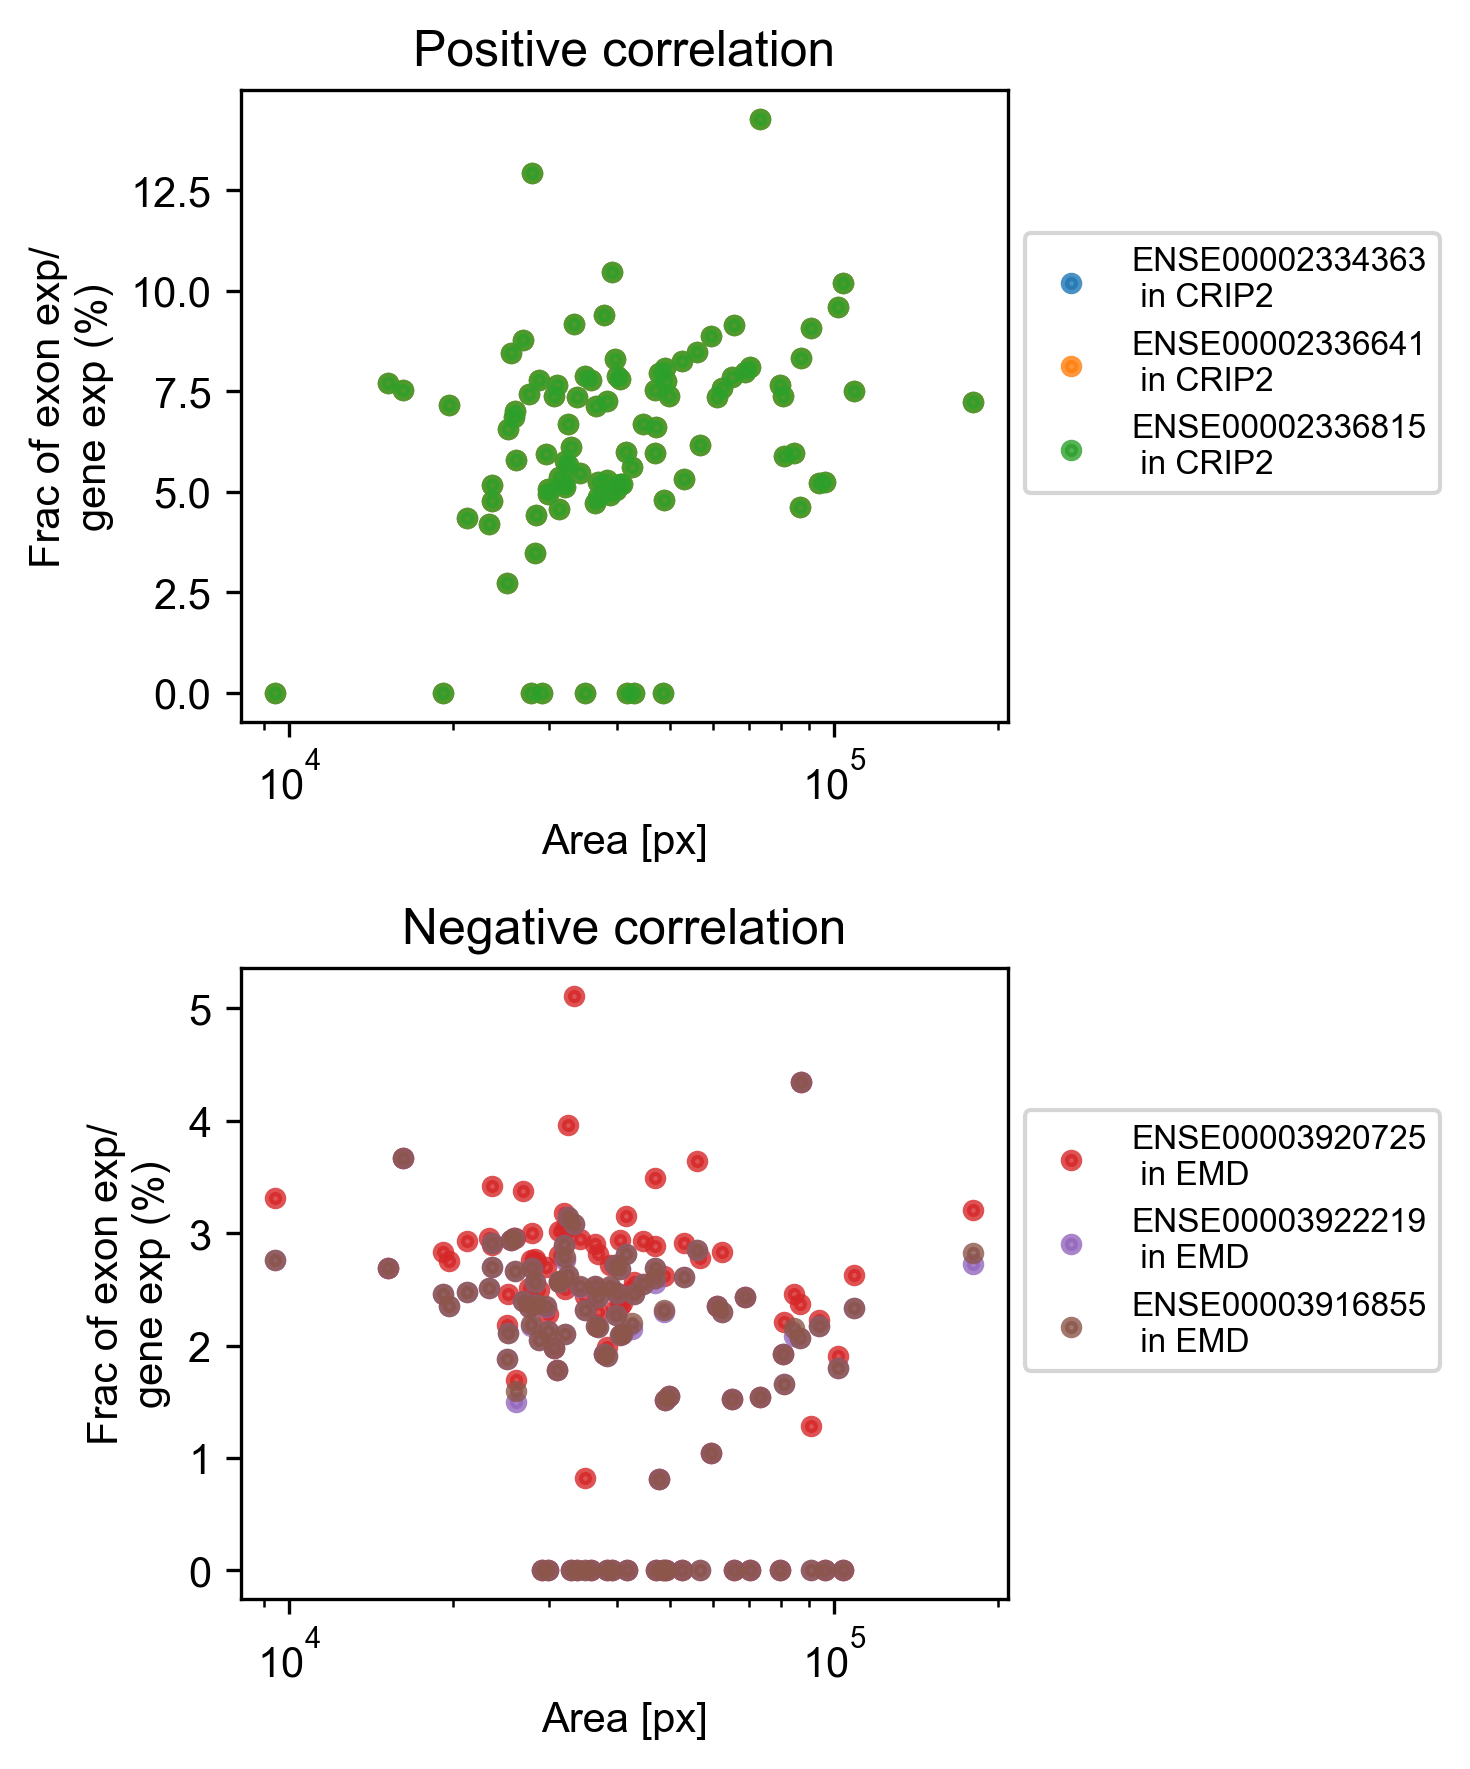

In [64]:
corr = pd.read_csv(save_figures + 'area_exon_fra.tsv', sep='\t', index_col=0)
exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)[adata.obs_names]

#######
feas = ['area']
labels = ['Area [px]']

n_exons = 3
colors = sns.color_palette('tab10', 2 * n_exons)
colors = [colors[: n_exons], colors[n_exons:]]

fig, axs = plt.subplots(2, 1, figsize=(5, 6), dpi=300)
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"

fea = feas[0]
exons_both = [
        corr.nlargest(n_exons, fea).index.tolist(),
        corr.nsmallest(n_exons, fea).index.tolist(),
    ]
for j, (ax, exons) in enumerate(zip(axs, exons_both)):
    for ie, exon in enumerate(exons):
        x = adata.obs[fea]
        y = exon_fra_df.loc[exon]
        g = corr.loc[exon]['gene_name']
        idx = np.argsort(x)
        ax.scatter(
            x[idx], y[idx] * 100, alpha=0.8, lw=2, color=colors[j][ie], s=10, label=f'{exon}\n in {g}'
        )
        
    ax.legend(fontsize=8, bbox_to_anchor=(1, 0.8))
    ax.set_xlabel(labels[0])
    ax.set_ylabel('Frac of exon exp/\ngene exp (%)')
    ax.set_xscale('log')

axs[0].set_title('Positive correlation')
axs[1].set_title('Negative correlation')
fig.tight_layout()

plt.savefig(save_figures + 'area_exon_fra.png')
plt.savefig(save_figures + 'area_exon_fra.pdf')

In [78]:
def plot_exon(feas, labels, gene, adata, exons):
    # filter out exons with 0 expression
    adata_e = adata[:, (adata.X > 0).sum(axis=0) > 0]

    colors = sns.color_palette('tab10', len(exons))

    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"

    fea = feas[0]
    x = adata.obs[fea]
    idx = np.argsort(x)
    for i, exon in enumerate(exons):
        y = exon_fra_df.loc[exon]
        ax.scatter(
            x[idx], y[idx] * 100, alpha=0.4, lw=2, color=colors[i], s=10, label=exon, 
        )

    ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
    ax.set_xlabel(labels[0])
    ax.set_ylabel('Frac of exon exp/\ngene exp(%)')
    ax.set_xscale('log')

    #ax.grid(True)
    ax.set_title(gene)
    fig.tight_layout()
    
    return {'fig': fig, 'ax': ax}

In [5]:
corr_all = pd.read_csv(save_figures + 'area_exon_fra_all.tsv', sep='\t', index_col=0)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


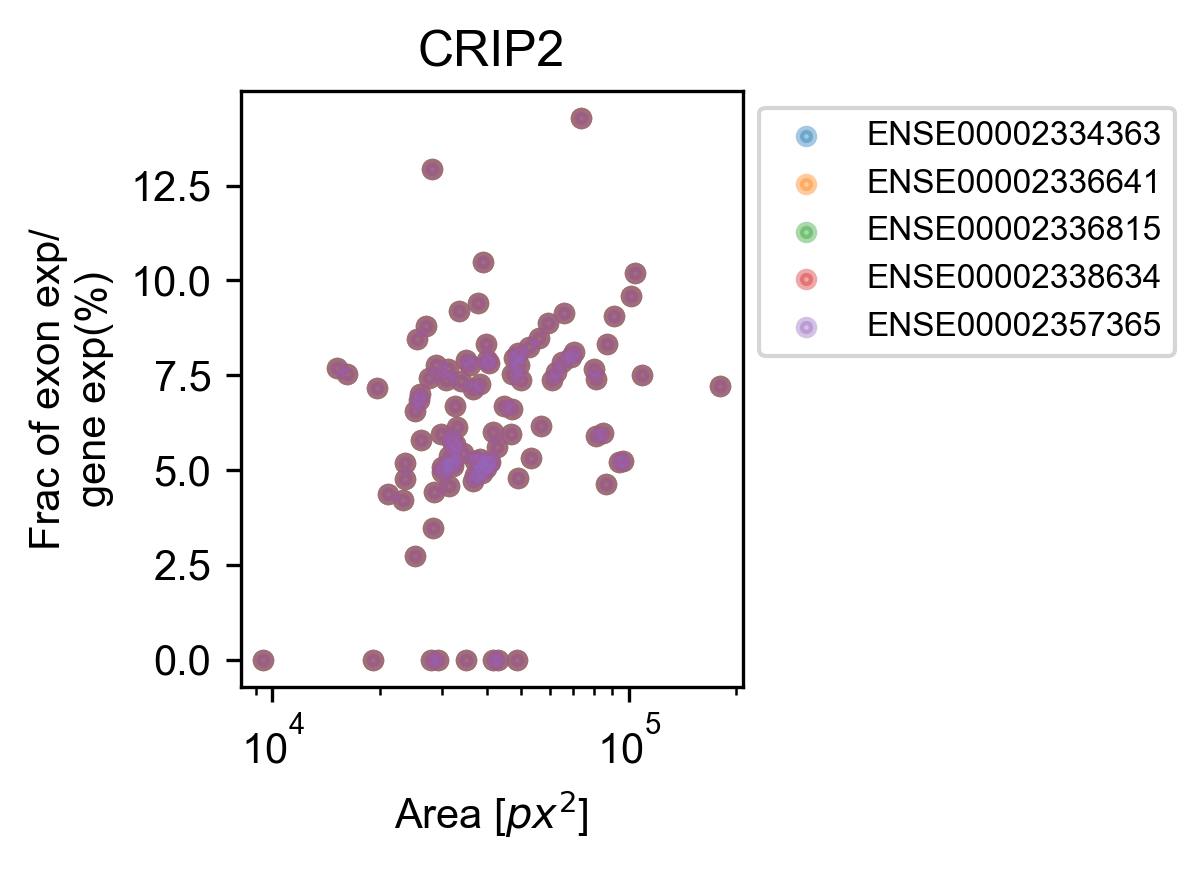

In [80]:
# write a function plot the frac vs area of all exons in a gene
feas = ['area']
labels = ['Area [$px^2$]']
gene = 'CRIP2'

# top 10 exons of the gene with expression > 0 
exons = corr_all[corr_all['gene_name'] == gene].nlargest(5, 'area').index

fig = plot_exon(feas, labels, gene, adata, exons)['fig']

fig.savefig(save_figures + f'area_exon_{gene}.png')
fig.savefig(save_figures + f'area_exon_{gene}.pdf')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


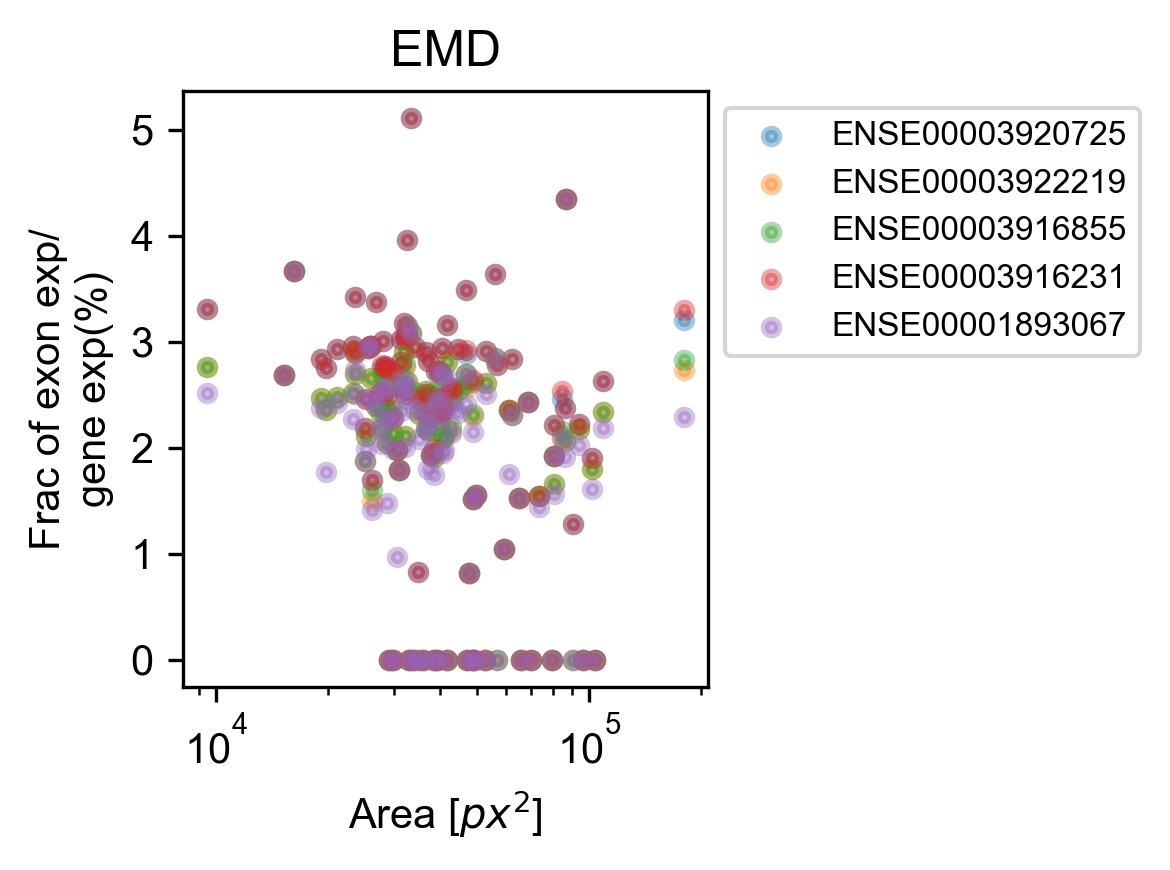

In [81]:
# write a function plot the frac vs area of all exons in a gene
feas = ['area']
labels = ['Area [$px^2$]']
gene = 'EMD'

# top 10 exons of the gene with expression > 0 
exons = corr_all[corr_all['gene_name'] == gene].nsmallest(5, 'area').index

fig = plot_exon(feas, labels, gene, adata, exons)['fig']

fig.savefig(save_figures + f'area_exon_{gene}.png')
fig.savefig(save_figures + f'area_exon_{gene}.pdf')

In [7]:
corr_all = pd.read_csv(save_figures + 'area_exon_fra_all.tsv', sep='\t', index_col=0)
exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)[adata.obs_names]

In [64]:
exon_fra_df['gene_n_id'] = [
    '{}: {} ({})'.format(adata.var.loc[ID]['gene_name'], adata.var.loc[ID]['exon_number'], ID)
    for ID in corr_all.index
]

corr_all['gene_n_id'] = [
    '{}: {} ({})'.format(adata.var.loc[ID]['gene_name'], adata.var.loc[ID]['exon_number'], ID)
    for ID in corr_all.index
]

In [72]:
corr_all[corr_all['gene_name'] == gene].nsmallest(n, 'area')['gene_n_id']

id
ENSE00003920725    EMD: 1 (ENSE00003920725)
ENSE00003922219    EMD: 1 (ENSE00003922219)
ENSE00003916855    EMD: 1 (ENSE00003916855)
ENSE00003916231    EMD: 1 (ENSE00003916231)
ENSE00001893067    EMD: 1 (ENSE00001893067)
ENSE00003919638    EMD: 1 (ENSE00003919638)
ENSE00001875000    EMD: 1 (ENSE00001875000)
ENSE00001868209    EMD: 1 (ENSE00001868209)
ENSE00001909734    EMD: 1 (ENSE00001909734)
ENSE00001913643    EMD: 1 (ENSE00001913643)
Name: gene_n_id, dtype: object

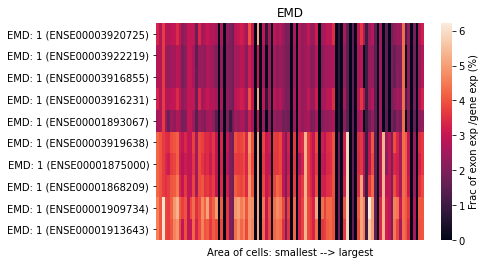

In [75]:
gene = 'EMD'
n = 10
exons = corr_all[corr_all['gene_name'] == gene].nsmallest(n, 'area')['gene_n_id']
cols = adata.obs['area'].sort_values().index
df =  exon_fra_df.set_index('gene_n_id').loc[exons][cols] * 100
df.columns = [col.split('_')[1] for col in df.columns]

fig, ax = plt.subplots()
sns.heatmap(df, ax=ax, cbar_kws={'label':'Frac of exon exp /gene exp (%)'},)
ax.set_ylabel(None)
ax.set_xlabel('Area of cells: smallest --> largest')
ax.set_title(gene)
ax.set_xticks([])
ax.set_xticklabels([])

fig.savefig(save_figures + f'{gene}_{n}.png', bbox_inches='tight', dpi=300)

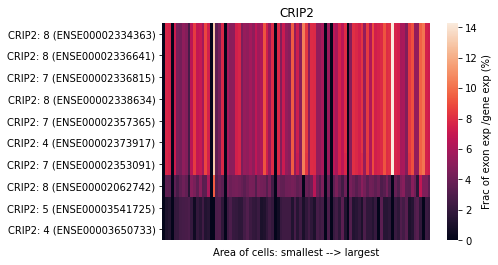

In [78]:
gene = 'CRIP2'
n = 10
exons = corr_all[corr_all['gene_name'] == gene].nlargest(n, 'area')['gene_n_id']
cols = adata.obs['area'].sort_values().index
df =  exon_fra_df.set_index('gene_n_id').loc[exons][cols] * 100
df.columns = [col.split('_')[1] for col in df.columns]

fig, ax = plt.subplots()
sns.heatmap(df, ax=ax, cbar_kws={'label':'Frac of exon exp /gene exp (%)'},)
ax.set_ylabel(None)
ax.set_xlabel('Area of cells: smallest --> largest')
ax.set_title(gene)
ax.set_xticks([])
ax.set_xticklabels([])

fig.savefig(save_figures + f'{gene}_{n}.png', bbox_inches='tight', dpi=300)